# Fit Model
This notebook fits a 3-state classification model on a training set and calculates metrics on a test set.

---

**Rule 9: Design Your Notebooks to Be Read, Run, and Explored.** We use ipywidgets to present the user with a pull-down menu to select a machine learning model.

---

In [1]:
# Default parameters
ml_method = "SVM"
test_size = 0.25

In [2]:
import pandas as pd
import mlutils
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import joblib
from ipywidgets import widgets

In [3]:
# column names
feature_col = "features" # feature vector
value_col = "foldClass" # fold class to be predicted

### Read data set with fold type classifications and feature vectors

In [4]:
df = pd.read_json("../intermediate_data/features.json")

In [5]:
print("Total number of data:", df.shape[0], "\n")
df.head(2)

Total number of data: 5370 



pdbChainId                                           sequence  \
1     16VP.A  SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...   
3     1A12.C  RRSPPADAIPKSKKVKVSHRSHSTEPGLVLTLGQGDVGQLGLGENV...   

                                 secondary_structure  length Exptl.  \
1  CCSCCCCCCCCHHHHHHHHHHHHTCTTHHHHHHHHHHCCCCCSTTS...     366   XRAY   
3  CCCCCCCCCCCCCCCCCCCTTCCCCCBEEEEEEECTTSTTCSCTTC...     413   XRAY   

   resolution  R-factor  FreeRvalue     alpha      beta      coil foldClass  \
1         2.1      0.19        0.26  0.469945  0.046448  0.483607     alpha   
3         1.7      0.19        0.22  0.038741  0.418886  0.542373      beta   

                                               ngram  \
1  [SRM, RMP, MPS, PSP, SPP, PPM, PMP, MPV, PVP, ...   
3  [RRS, RSP, SPP, PPA, PAD, ADA, DAI, AIP, IPK, ...   

                                            features  
1  [-2.6183412084, -0.37215537190000003, 0.140630...  
3  [-2.2319736748, -0.4659580593, -0.038827395300...

## Split dataset into a training set and a test set

In [6]:
train, test = train_test_split(df, test_size=test_size, random_state=13, stratify=df[value_col])
print("Training set size:", train.shape[0], "\n")
print(train[value_col].value_counts())
print()
print("Test set size:", test.shape[0], "\n")
print(test[value_col].value_counts())

Training set size: 4027 

alpha         2107
alpha+beta    1266
beta           654
Name: foldClass, dtype: int64

Test set size: 1343 

alpha         703
alpha+beta    422
beta          218
Name: foldClass, dtype: int64


## Select a Classification Method (default SVM)
Using the pull-down menu, you can select one of three machine learning models and compare the performance.

In [7]:
method = widgets.Dropdown(options=['SVM', 'LogisticRegression', "NeuralNetwork"],value=ml_method, description='Method')

In [8]:
display(method)

Dropdown(description='Method', options=('SVM', 'LogisticRegression', 'NeuralNetwork'), value='SVM')

## Train a classifier

In [9]:
if (method.value == 'SVM'):
    classifier = svm.SVC(gamma='auto', class_weight='balanced', random_state=13, probability=True)
elif (method.value == 'LogisticRegression'):
    classifier = LogisticRegression(class_weight='balanced', random_state=13, solver='lbfgs', multi_class='auto', max_iter=500)
elif (method.value == 'NeuralNetwork'):
    # Neural network with one hidden layer of 20 nodes
    classifier = MLPClassifier(hidden_layer_sizes = (20), random_state=13, early_stopping=True)


classifier.fit(train[feature_col].tolist(), train[value_col])

SVC(class_weight='balanced', gamma='auto', probability=True, random_state=13)

## Make prediction for the test set

In [10]:
predicted = classifier.predict(test[feature_col].tolist())
expected = test[value_col]

## Calculate metrics for the test set

Classification metrics:

              precision    recall  f1-score   support

       alpha       0.91      0.82      0.86       703
  alpha+beta       0.72      0.78      0.75       422
        beta       0.73      0.83      0.77       218

    accuracy                           0.81      1343
   macro avg       0.78      0.81      0.79      1343
weighted avg       0.82      0.81      0.81      1343



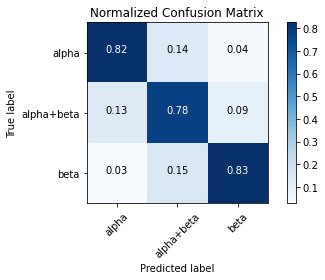

In [11]:
print("Classification metrics:\n")
print(metrics.classification_report(expected, predicted))

cm = metrics.confusion_matrix(expected, predicted)
mlutils.plot_confusion_matrix(cm, classifier.classes_, normalize=True, title='Normalized Confusion Matrix')

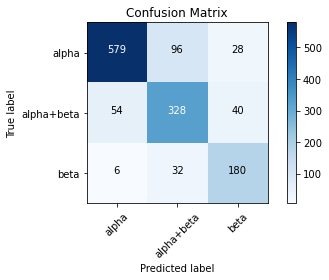

In [12]:
mlutils.plot_confusion_matrix(cm, classifier.classes_, normalize=False, title='Confusion Matrix')

## Results
The three classification methods: SVM, Logistic Regression, and Neural Network perform about the same on the test dataset. We have not optimized any parameters. We leave this as an excercise for the reader.

For all three methods, the prediction of the mixed class: alpha+beta has the lowest precision and recall. 

**Limitations of the Model**

The feature vectors are created by summing ProtVectors for all 3-grams of a protein sequence and this process averages individual contributions. This step may contribute to the lower performance for the alpha+beta class, because alpha and beta related features are averaged together. In addition, the beta class is underrepresented.

The limiting factor appears to the expressiveness of the feature vector using the ProtVec model. Furthermore, we used a cutoff of 25% alpha and/or beta content to define the fold classes. This means that the model will not perform well on protein sequences with minimal alpha or beta content.

Alternative feature vectors can be easily explored by replacing the CalculateFeatures step with another method.

## Save the Classification Model

In [13]:
joblib.dump(classifier, "../intermediate_data/classifier")

['../intermediate_data/classifier']

## Next Step
After you saved the classification model here, run the next step in the workflow [4-Predict.ipynb](./4-Predict.ipynb) or go back go back to [0-Workflow.ipynb](./0-Workflow.ipynb).

---

**Authors:** [Peter W. Rose](mailto:pwrose.ucsd@gmail.com), Shih-Cheng Huang, UC San Diego, October 1, 2018

---